<a href="https://colab.research.google.com/github/arunavaangshuman/PDE/blob/main/ULA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip
!pip install cirq

     |████████████████████████████████| 1.5MB 5.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 1.8 MB 4.5 MB/s 
     |████████████████████████████████| 1.3 MB 20.1 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [ ]:
import cirq

In [ ]:
!pip install -q qsimcirq --quiet

     |████████████████████████████████| 103 kB 5.3 MB/s 
     |████████████████████████████████| 191 kB 18.7 MB/s 


In [ ]:
import numpy as np

In [ ]:
import numpy as np
import cirq

#Invertible general SO(4) unitary gate
class SO4(cirq.Gate):
    #thetas := list of 6 variational parameters for this SO4 block
    def __init__(self, thetas, inverse=False):
        if (len(thetas)!=6):
            raise ValueError("thetas must be a list of 6 variational parameters")
        self.thetas=thetas
        self.inverse=inverse
    
    def _decompose_(self, q):
        #SO(4) gate object takes two qubits as input
        if (not self.inverse):
            yield cirq.ry(self.thetas[0]).on(q[0])
            yield cirq.ry(self.thetas[1]).on(q[1])
            yield cirq.CNOT(q[0], q[1])
            yield cirq.ry(self.thetas[2]).on(q[0])
            yield cirq.ry(self.thetas[3]).on(q[1])
            yield cirq.CNOT(q[0], q[1])
            yield cirq.ry(self.thetas[4]).on(q[0])
            yield cirq.ry(self.thetas[5]).on(q[1])
            
        else:
            yield cirq.ry(-self.thetas[5]).on(q[1])
            yield cirq.ry(-self.thetas[4]).on(q[0])
            yield cirq.CNOT(q[0], q[1])
            yield cirq.ry(-self.thetas[3]).on(q[1])
            yield cirq.ry(-self.thetas[2]).on(q[0])
            yield cirq.CNOT(q[0], q[1])
            yield cirq.ry(-self.thetas[1]).on(q[1])
            yield cirq.ry(-self.thetas[0]).on(q[0])
            
        
    def _num_qubits_(self):
        #We are required to implement this method, 
        #it specifies the number of qubits our gate acts on
        return 2
    
    def _unitary_(self):
        #Some other method we need in order to get inverses of U to work
        #as we will need them in our circuits
        return cirq.unitary(cirq.Circuit(self._decompose_(cirq.LineQubit.range(2))))


In [ ]:
class AltSO4(cirq.Gate):
    #thetas := list of 6 variational parameters for this SO4 block
    def __init__(self, thetas, inverse=False):
        if (len(thetas)!=6):
            raise ValueError("thetas must be a list of 6 variational parameters")
        self.thetas=thetas
        self.inverse=inverse
    
    def _decompose_(self, q):
        #AltSO(4) gate object takes two qubits as input
        if (not self.inverse):
            yield cirq.rz(np.pi/2).on(q[0])
            yield cirq.rz(np.pi/2).on(q[1])
            yield cirq.ry(np.pi/2).on(q[1])
            yield cirq.CNOT(q[1], q[0])
            yield cirq.rz(self.thetas[0]).on(q[0])
            yield cirq.ry(self.thetas[1]).on(q[0])
            yield cirq.rz(self.thetas[2]).on(q[0])
            yield cirq.rz(self.thetas[3]).on(q[1])
            yield cirq.ry(self.thetas[4]).on(q[1])
            yield cirq.rz(self.thetas[5]).on(q[1])
            yield cirq.CNOT(q[1], q[0])
            yield cirq.rz(-np.pi/2).on(q[0])
            yield cirq.ry(-np.pi/2).on(q[1])
            yield cirq.rz(-np.pi/2).on(q[1])
            
            
        else:
            yield cirq.rz(np.pi/2).on(q[0])
            yield cirq.rz(np.pi/2).on(q[1])
            yield cirq.ry(np.pi/2).on(q[1])
            yield cirq.CNOT(q[1], q[0])
            yield cirq.rz(-self.thetas[0]).on(q[0])
            yield cirq.ry(-self.thetas[1]).on(q[0])
            yield cirq.rz(-self.thetas[2]).on(q[0])
            yield cirq.rz(-self.thetas[3]).on(q[1])
            yield cirq.ry(-self.thetas[4]).on(q[1])
            yield cirq.rz(-self.thetas[5]).on(q[1])
            yield cirq.CNOT(q[1], q[0])
            yield cirq.rz(-np.pi/2).on(q[0])
            yield cirq.ry(-np.pi/2).on(q[1])
            yield cirq.rz(-np.pi/2).on(q[1])
           
            
        
    def _num_qubits_(self):
        #We are required to implement this method, 
        #it specifies the number of qubits our gate acts on
        return 2
    
    def _unitary_(self):
        #Some other method we need in order to get inverses of U to work
        #as we will need them in our circuits
        return cirq.unitary(cirq.Circuit(self._decompose_(cirq.LineQubit.range(2))))
    

In [ ]:
#Invertible Universal Layered Ansatz. Acts on n qubits
class U(cirq.Gate):
    def __init__(self, n, d, l, inverse=False):
        #n := number of qubits
        #d := depth (number of layers)
        #l := list of variational parameters. Must be 6*(n-1)*d parameters
        #we specify the variational parameter when we declare a U gate object
        if (len(l)!=6*(n-1)*d):
            raise ValueError("Incorrect number of parameters. l must be of length 6*(n-1)*d")
        self.n=n
        self.d=d
        self.l=l
        self.inverse=inverse
    
    def _decompose_(self, q):
        #U gate object takes in n qubits as input
        if (not self.inverse):
            for i in range(self.d):
                for j in range(0, self.n-1, 2):
                    yield AltSO4(self.l[6*(self.n-1)*i+6*j:6*(self.n-1)*i+6*j+6]).on(q[j], q[j+1])
                for j in range(1, self.n-1, 2):
                    yield AltSO4(self.l[6*(self.n-1)*i+6*j:6*(self.n-1)*i+6*j+6]).on(q[j], q[j+1])
        else:
            for i in range(self.d-1, -1, -1):
                if (n%2==1):
                    for j in range(self.n-2, -1, -2):
                        yield AltSO4(self.l[6*(self.n-1)*i+6*j:6*(self.n-1)*i+6*j+6], True).on(q[j], q[j+1])
                    for j in range(self.n-3, -1, -2):
                        yield AltSO4(self.l[6*(self.n-1)*i+6*j:6*(self.n-1)*i+6*j+6], True).on(q[j], q[j+1])
                else:
                    for j in range(self.n-3, -1, -2):
                        yield AltSO4(self.l[6*(self.n-1)*i+6*j:6*(self.n-1)*i+6*j+6], True).on(q[j], q[j+1])
                    for j in range(self.n-2, -1, -2):
                        yield AltSO4(self.l[6*(self.n-1)*i+6*j:6*(self.n-1)*i+6*j+6], True).on(q[j], q[j+1])
                    
        
    def _num_qubits_(self):
        #We are required to implement this method, 
        #it specifies the number of qubits our gate acts on
        return self.n   
    
    def _unitary_(self):
        #Some other method we need in order to get inverses of U to work
        #as we will need them in our circuits
        return cirq.unitary(cirq.Circuit(self._decompose_(cirq.LineQubit.range(self.n))))


In [ ]:
def checkwave(l,d,n):
    #create circuit object for adding gates to
    circuit = cirq.Circuit()
    #specify number of qubits we want in our circuit
    q = [cirq.GridQubit(0, i) for i in range(n)]
    
    #Add our custom gate class U to our circuit and make sure it acts
    #on all qubits *q
    circuit.append(U(n=n,d=d,l=l[1:d*6*(n-1)+1]).on(*q))
    
    param=d*6*(n-1)+1
    for i in range(n):
        circuit.append(cirq.rz(l[param]).on(q[i]))
        param+=1
    
    circuit.append(cirq.qft(*q, without_reverse=True)**-1)
    
    #Create simulator object
    simulator = cirq.Simulator()
    
    #Direct wavefunction access
    result = simulator.simulate(circuit).state_vector()
    
    #create final state 
    func = l[0]*np.real(result)
    return func

In [ ]:
d=1
n=6

In [ ]:

def f(l):
    x=np.linspace(0,1,2**n)
    return np.linalg.norm(checkwave(l,d,n)-np.sin(np.pi*x)-np.sin(2*np.pi*x))**2

In [ ]:
bounds = [[0,15]] #first bound is lambda0, best choice of bounds usually
#depends on number of qubits we are using

#the rest of the bounds are the angle theta in Ry(theta)
for i in range(d*6*(n-1)+n):
    bounds.append([0,2*np.pi])

In [ ]:
budget = 10000

In [ ]:
!python -m pip install scikit-quant

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-quant: filename=scikit_quant-0.8.1-py3-none-any.whl size=21419 sha256=ffa44f8efbf90f5ef1cd9e9c612ceb0573989462052069e76a5cd8c0133aafd1
  Stored in directory: /root/.cache/pip/wheels/b5/cf/7f/7b8580b82c80315360370967333d349deeab3c51388294d0ce
  Created wheel for SQCommon: filename=SQCommon-0.3.2-py3-none-any.whl size=3280 sha256=501d620763deba9a3b71605d016ccb0f0c6f547205af8e8ce93b3608a0e8178d
  Stored in directory: /root/.cache/pip/wheels/27/c6/29/d8db0e4d659442259068990da027de2c650d6ff5273b644127
  Created wheel for SQImFil: filename=SQImFil-0.3.7-py3-none-any.whl size=29088 sha256=00aa5d

In [ ]:
import skquant.opt as skqopt #optimization routines
from matplotlib import pyplot as plt #plotting tool

In [ ]:
x0=np.concatenate(([10*np.random.random()],2*np.pi*np.random.rand(d*6*(n-1)+n)))

#Optimize using Imfil
result, history = skqopt.minimize(f, x0, bounds, budget, method='imfil')

In [ ]:
print(cirq.unitary(cirq.rz(-np.pi/2)))

[[0.70710678+0.70710678j 0.        +0.j        ]
 [0.        +0.j         0.70710678-0.70710678j]]


In [ ]:
linit=result.optpar

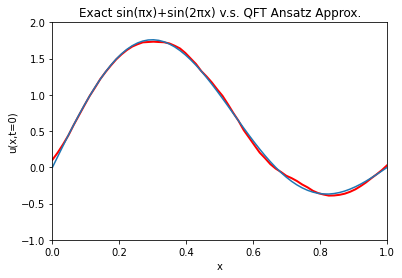

In [ ]:
fig = plt.figure()
y=np.linspace(0,1,2**n)
ax = plt.axes(xlim=(0, 1), ylim=(-1, 2))
line, = ax.plot(y, checkwave(linit,d,n), 'r', lw=2)
line2, = ax.plot(y, np.sin(np.pi*y)+np.sin(2*np.pi*y))
plt.xlabel('x')
plt.ylabel('u(x,t=0)')
plt.title('Exact sin(πx)+sin(2πx) v.s. QFT Ansatz Approx.')
plt.savefig('qftplot.png')

In [ ]:
np.linalg.norm(checkwave(linit,d,n)-np.sin(np.pi*y)-np.sin(2*np.pi*y))

0.22265063368620935

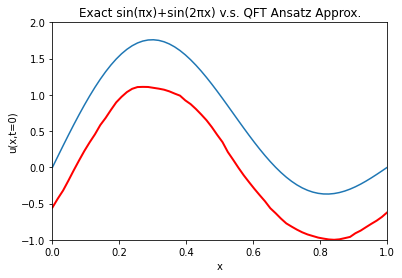

In [ ]:
#with out inverse QFT
fig = plt.figure()
y=np.linspace(0,1,2**n)
ax = plt.axes(xlim=(0, 1), ylim=(-1, 2))
line, = ax.plot(y, checkwave(linit,d,n), 'r', lw=2)
line2, = ax.plot(y, np.sin(np.pi*y)+np.sin(2*np.pi*y))
plt.xlabel('x')
plt.ylabel('u(x,t=0)')
plt.title('Exact sin(πx)+sin(2πx) v.s. QFT Ansatz Approx.')
plt.savefig('qftplot.png')

In [ ]:
np.linalg.norm(checkwave(linit,d,n)-np.sin(np.pi*y)-np.sin(2*np.pi*y))

5.015375012851139

In [ ]:
print(cirq.unitary(cirq.X))

[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
